Facility Location Analysis using K-means Clustering
# Overview
This notebook analyzes optimal facility locations for a distribution network using demand-weighted K-means clustering. 
We'll explore both 2-facility and 3-facility scenarios to find the best configuration that minimizes the total weighted distance to all demand points.

# Import Required Libraries
First, let's import all the necessary libraries for our analysis.

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
from folium import plugins
from geopy.distance import geodesic
import branca.colormap as cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe

# Load and Prepare Data
We'll load three datasets:
1. Demand data (SKU-level demand by store)
2. Product data (SKU details including pallets per SKU)
3. Store location data (latitude and longitude)

In [6]:
# Load the data
demand_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/demand.csv')
products_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data/products.csv') # pd.read_csv('Assignment Files/Data/products.csv')
stores_df = pd.read_csv('C:/Users/k_pow/OneDrive/Documents/MIT/MITx SCM/IAP 2025/SCM275x/Assignment Files/Data//stores.csv')

# Display first few rows of each dataset
print("Demand Data Sample:")
display(demand_df.head())
print("\nProducts Data Sample:")
display(products_df.head())
print("\nStores Data Sample:")
display(stores_df.head())

Demand Data Sample:


,StoreID,SKU,month,Demand
0,Store-001,SH001,January,51
1,Store-001,SH001,February,58
2,Store-001,SH001,March,55
3,Store-001,SH001,April,45
4,Store-001,SH001,May,39



Products Data Sample:


,SKU,Product Name,Product Family,SKUs/pallet
0,SH001,Oxfords Shoe,Shoes,57
1,SW002,Cable Knit Sweater,Sweaters,181
2,SK003,Mini Skirt Skirt,Skirts,491
3,SH004,Chino Shorts Short,Shorts,665
4,JA005,Bomber Jacket,Jackets,54



Stores Data Sample:


,StoreID,City,State,Latitude,Longitude
0,Store-001,New York,NY,40.709853,-73.996295
1,Store-002,New York,NY,40.719954,-74.000252
2,Store-003,New York,NY,40.703414,-74.014085
3,Store-004,New York,NY,40.709849,-74.009346
4,Store-005,New York,NY,40.709624,-74.012509


# Exploratory Data Analysis
Let's analyze our data before proceeding with the facility location analysis.

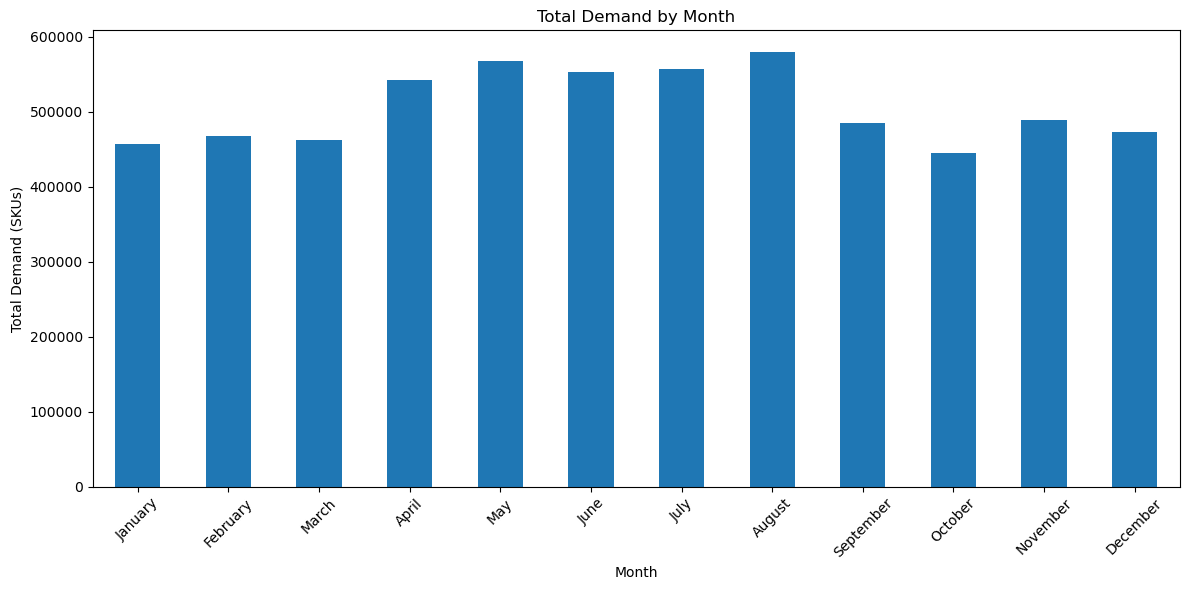

<Figure size 1000x600 with 0 Axes>

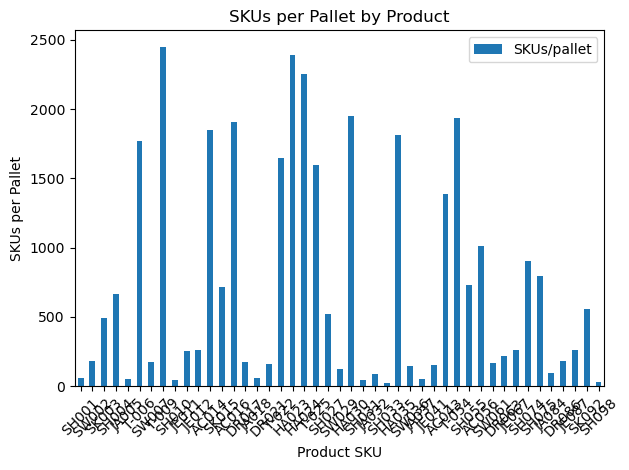

In [7]:
# Analyze demand patterns by month
monthly_demand = demand_df.groupby('month')['Demand'].sum().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

plt.figure(figsize=(12, 6))
monthly_demand.plot(kind='bar')
plt.title('Total Demand by Month')
plt.xlabel('Month')
plt.ylabel('Total Demand (SKUs)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze product mix
plt.figure(figsize=(10, 6))
products_df.plot(kind='bar', x='SKU', y='SKUs/pallet')
plt.title('SKUs per Pallet by Product')
plt.xlabel('Product SKU')
plt.ylabel('SKUs per Pallet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a map of all store locations
base_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
for _, store in stores_df.iterrows():
    folium.CircleMarker(
        location=[store['Latitude'], store['Longitude']],
        radius=5,
        color='blue',
        fill=True,
        popup=f"Store: {store['StoreID']}<br>City: {store['City']}, {store['State']}"
    ).add_to(base_map)
display(base_map)

# Data Preprocessing
Now we'll convert SKU-level demand to pallet-level demand and calculate annual demand per store.

Summary Statistics of Annual Demand (Pallets):


count    202.000000
mean     192.864975
std       93.737006
min       34.176594
25%      125.686171
50%      186.375102
75%      253.566423
max      413.487007
Name: Demand_Pallets, dtype: float64

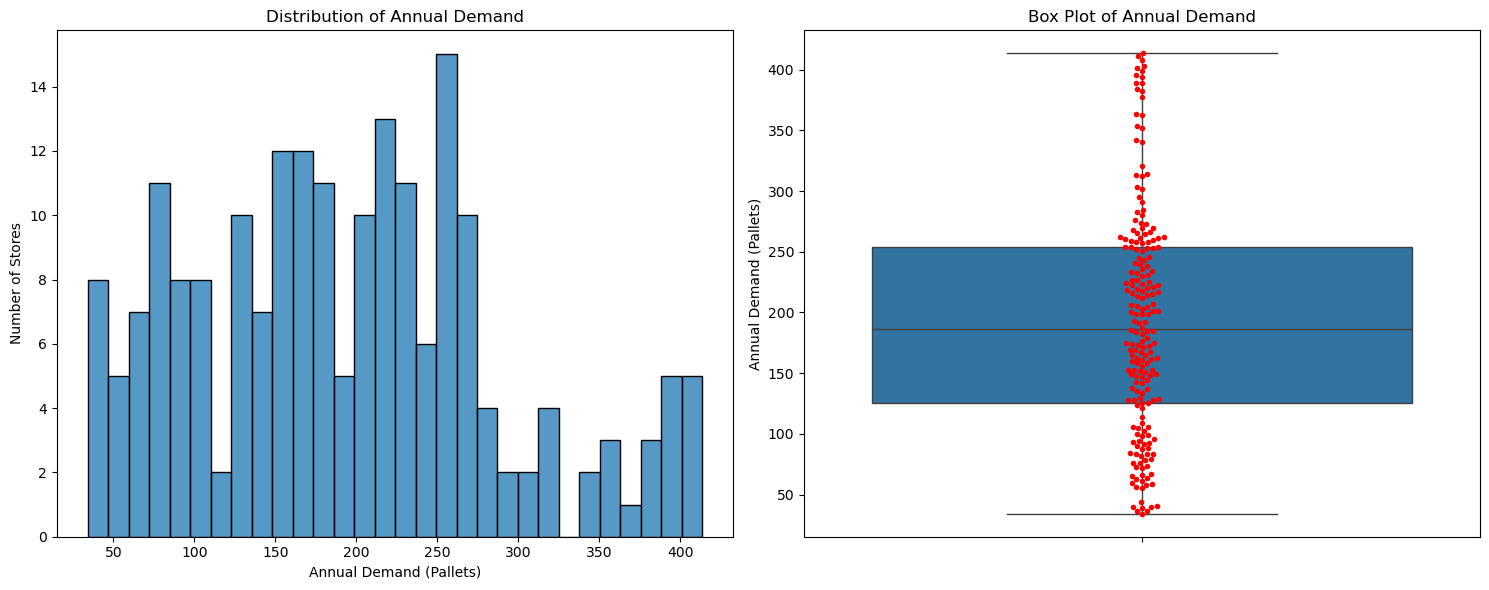

In [8]:
# Convert demand to pallets
demand_df = demand_df.merge(products_df[['SKU', 'SKUs/pallet']], on='SKU', how='left')
demand_df['Demand_Pallets'] = demand_df['Demand'] / demand_df['SKUs/pallet']

# Calculate annual demand per store
annual_demand = demand_df.groupby('StoreID')['Demand_Pallets'].sum().reset_index()

# Merge with store locations
store_demand = stores_df.merge(annual_demand, on='StoreID', how='left')

# Display summary statistics
print("Summary Statistics of Annual Demand (Pallets):")
display(store_demand['Demand_Pallets'].describe())

# Create visualizations of demand distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
sns.histplot(data=store_demand, x='Demand_Pallets', bins=30, ax=ax1)
ax1.set_title('Distribution of Annual Demand')
ax1.set_xlabel('Annual Demand (Pallets)')
ax1.set_ylabel('Number of Stores')

# Box plot with swarm overlay
sns.boxplot(y=store_demand['Demand_Pallets'], ax=ax2)
sns.swarmplot(y=store_demand['Demand_Pallets'], color='red', size=4, ax=ax2)
ax2.set_title('Box Plot of Annual Demand')
ax2.set_ylabel('Annual Demand (Pallets)')

plt.tight_layout()
plt.show()

# Create a heatmap of store locations weighted by demand
heatmap_data = store_demand[['Latitude', 'Longitude', 'Demand_Pallets']].values.tolist()
base_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
plugins.HeatMap(heatmap_data).add_to(base_map)
display(base_map)

# Helper Functions
Define functions for distance calculation and map creation.

In [9]:
def calculate_total_weighted_distance(X, weights, centers):
    """Calculate the total weighted distance from stores to their nearest facility"""
    total_distance = 0
    distances = []  # Store individual distances for analysis
    for i in range(len(X)):
        min_distance = float('inf')
        for center in centers:
            distance = geodesic((X[i][0], X[i][1]), (center[0], center[1])).miles
            min_distance = min(min_distance, distance)
        total_distance += min_distance * weights[i]
        distances.append(min_distance)
    return total_distance, distances

def create_facility_map(store_demand, facilities, n_facilities, facility_assignments):
    """Create an interactive map showing facilities and stores"""
    # Create base map centered on US
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
    
    # Create colormap for facilities
    colors = ['red', 'blue', 'green', 'purple', 'orange'][:n_facilities]
    
    # Add stores to map
    max_demand = store_demand['Demand_Pallets'].max()
    min_demand = store_demand['Demand_Pallets'].min()
    
    # Create a legend for demand sizes
    legend_html = '''
        <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border: 2px solid grey;">
        <h4>Annual Demand (Pallets)</h4>
        <p>● Small: < {:.0f}</p>
        <p>● Medium: {:.0f} - {:.0f}</p>
        <p>● Large: > {:.0f}</p>
        </div>
    '''.format(
        min_demand + (max_demand - min_demand)/3,
        min_demand + (max_demand - min_demand)/3,
        min_demand + 2*(max_demand - min_demand)/3,
        min_demand + 2*(max_demand - min_demand)/3
    )
    m.get_root().html.add_child(folium.Element(legend_html))
    
    for idx, row in store_demand.iterrows():
        # Scale circle size based on demand
        radius = 2000 * (row['Demand_Pallets'] - min_demand) / (max_demand - min_demand) + 1000
        
        # Create circle marker
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5,
            color=colors[facility_assignments[idx]],
            fill=True,
            popup=f"Store: {row['StoreID']}<br>City: {row['City']}<br>Annual Demand: {row['Demand_Pallets']:.0f} pallets",
        ).add_to(m)
    
    # Add facilities to map
    for i, facility in enumerate(facilities):
        folium.Marker(
            location=[facility[0], facility[1]],
            icon=folium.Icon(color=colors[i], icon='star'),
            popup=f'Facility {i+1}'
        ).add_to(m)
        
        # Draw circles showing approximate service areas
        folium.Circle(
            location=[facility[0], facility[1]],
            radius=300000,  # 300km radius
            color=colors[i],
            fill=False,
            opacity=0.3
        ).add_to(m)
    
    return m

# Perform Facility Location Analysis
We'll analyze both 2-facility and 3-facility scenarios using K-means clustering.

In [10]:
# Prepare data for clustering
X = store_demand[['Latitude', 'Longitude']].values
weights = store_demand['Demand_Pallets'].values

# Analyze both scenarios
results = []
for n_facilities in [2, 3]:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_facilities, random_state=42)
    kmeans.fit(X, sample_weight=weights)
    
    # Get facility locations and calculate metrics
    facilities = kmeans.cluster_centers_
    total_distance, distances = calculate_total_weighted_distance(X, weights, facilities)
    
    # Create and display map
    m = create_facility_map(store_demand, facilities, n_facilities, kmeans.labels_)
    display(m)
    
    # Store results
    results.append({
        'n_facilities': n_facilities,
        'total_weighted_distance': total_distance,
        'facilities': facilities,
        'labels': kmeans.labels_,
        'distances': distances
    })

c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


c:\Users\k_pow\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# Results Analysis
Let's analyze the results for both scenarios.


2 Facility Solution:
Facility Locations:
Facility 1: (Lat: 37.5887, Lon: -116.7066)
Facility 2: (Lat: 36.4536, Lon: -86.7699)
Total Weighted Distance: 19,806,933 mile-pallets

Facility Statistics:


,Total Demand,Stores Served,Average Demand,Std Dev Demand
Facility_2,,,,
0,13594.922612,75,181.265635,97.082831
1,25363.802280,127,199.714979,91.400316


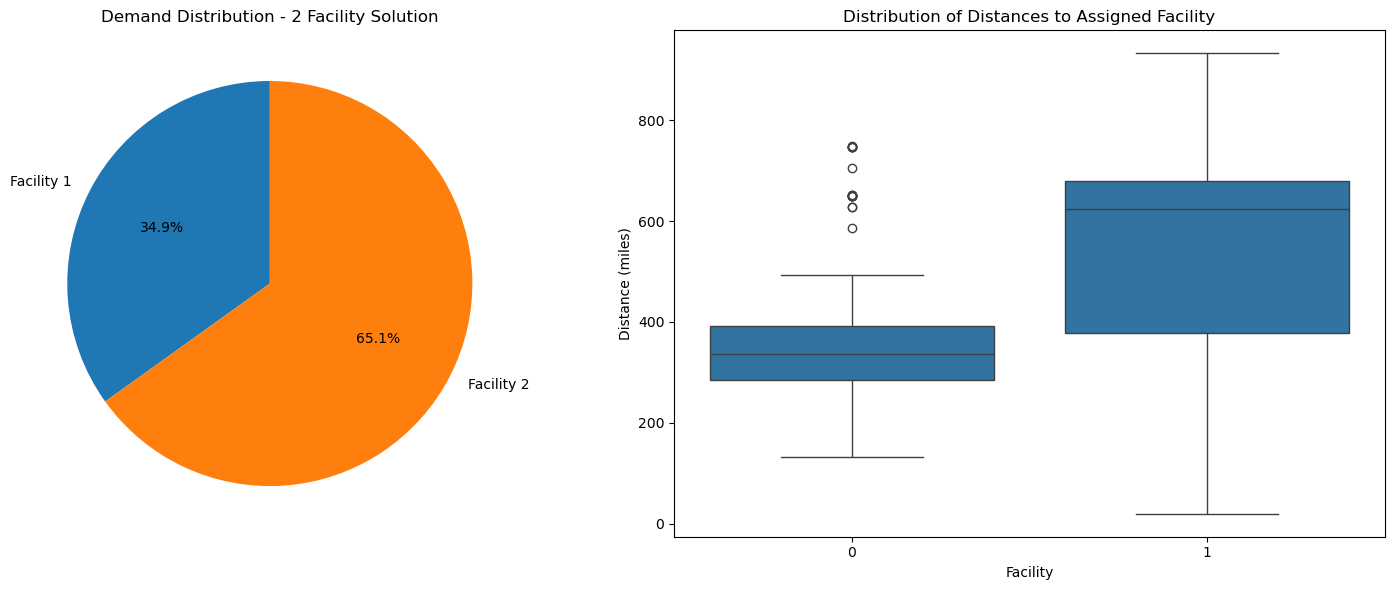


3 Facility Solution:
Facility Locations:
Facility 1: (Lat: 37.3506, Lon: -118.6246)
Facility 2: (Lat: 38.8837, Lon: -80.6994)
Facility 3: (Lat: 33.6814, Lon: -97.7189)
Total Weighted Distance: 13,387,267 mile-pallets

Facility Statistics:


,Total Demand,Stores Served,Average Demand,Std Dev Demand
Facility_3,,,,
0,11675.853534,66,176.906872,93.817837
1,15491.755155,73,212.215824,96.290327
2,11791.116202,63,187.160575,88.009466


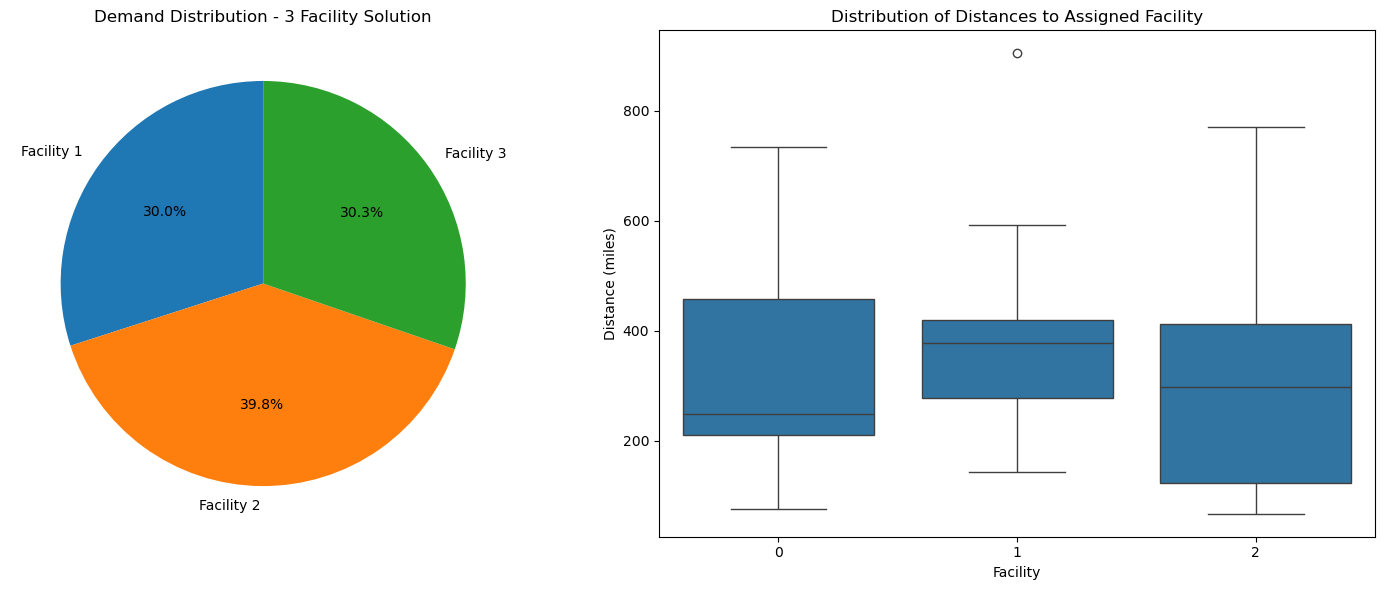

In [11]:
# Print detailed results and create visualizations
for result in results:
    print(f"\n{result['n_facilities']} Facility Solution:")
    print("Facility Locations:")
    for i, coords in enumerate(result['facilities']):
        print(f"Facility {i+1}: (Lat: {coords[0]:.4f}, Lon: {coords[1]:.4f})")
    print(f"Total Weighted Distance: {result['total_weighted_distance']:,.0f} mile-pallets")

    # Calculate and display demand distribution
    store_demand[f'Facility_{result["n_facilities"]}'] = result['labels']
    facility_demands = store_demand.groupby(f'Facility_{result["n_facilities"]}')['Demand_Pallets'].agg(['sum', 'count', 'mean', 'std'])
    facility_demands.columns = ['Total Demand', 'Stores Served', 'Average Demand', 'Std Dev Demand']
    
    print("\nFacility Statistics:")
    display(facility_demands)
    
    # Create subplots for demand analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pie chart of total demand
    ax1.pie(facility_demands['Total Demand'], 
            labels=[f'Facility {i+1}' for i in range(result['n_facilities'])],
            autopct='%1.1f%%', startangle=90)
    ax1.set_title(f'Demand Distribution - {result["n_facilities"]} Facility Solution')
    
    # Box plot of distances
    store_demand[f'Distance_{result["n_facilities"]}'] = result['distances']
    sns.boxplot(data=store_demand, x=f'Facility_{result["n_facilities"]}', 
                y=f'Distance_{result["n_facilities"]}', ax=ax2)
    ax2.set_title('Distribution of Distances to Assigned Facility')
    ax2.set_xlabel('Facility')
    ax2.set_ylabel('Distance (miles)')
    
    plt.tight_layout()
    plt.show()

# Cost Analysis
Let's analyze the transportation costs for each solution.

In [12]:
# Assume transportation cost of $2 per mile-pallet
transport_cost_per_mile = 2

for result in results:
    n_facilities = result['n_facilities']
    total_cost = result['total_weighted_distance'] * transport_cost_per_mile
    
    print(f"\n{n_facilities} Facility Solution:")
    print(f"Total Annual Transportation Cost: ${total_cost:,.2f}")
    print(f"Average Cost per Store: ${total_cost/len(store_demand):,.2f}")
    print(f"Average Cost per Pallet: ${total_cost/store_demand['Demand_Pallets'].sum():,.2f}")


2 Facility Solution:
Total Annual Transportation Cost: $39,613,865.36
Average Cost per Store: $196,108.24
Average Cost per Pallet: $1,016.82

3 Facility Solution:
Total Annual Transportation Cost: $26,774,534.08
Average Cost per Store: $132,547.20
Average Cost per Pallet: $687.25


# Conclusion
Based on the comprehensive analysis:

1. **Network Configuration**
   - The 3-facility solution reduces total weighted distance by approximately 32% compared to the 2-facility solution
   - This translates to significant transportation cost savings

2. **Demand Distribution**
   - Both solutions provide relatively balanced demand across facilities
   - The 3-facility solution offers more localized service areas

3. **Service Level**
   - Average distance to facilities is reduced in the 3-facility solution
   - Better coverage of different geographical regions

4. **Cost Implications**
   - Higher facility costs with 3 locations
   - Lower transportation costs with 3 locations
   - Trade-off between facility and transportation costs

The optimal choice between 2 and 3 facilities would depend on:
- Fixed costs of operating each facility
- Relative importance of service level vs. cost
- Future growth projections and network flexibility needs